In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC as SVM
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv') # has rows 0 - 890
test_data_loading = pd.read_csv('/kaggle/input/titanic/test.csv') # has rows 892 - 1309
test_data_loading

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [3]:
data = pd.concat([train_data, test_data_loading], ignore_index=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df
    
data = preprocess(data)

In [6]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0.0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1.0,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1.0,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1.0,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0.0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1046 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1307 non-null   object 
 12  Ticket_number  1309 non-null   object 
 13  Ticket_item    1309 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [9]:
data = data.drop(['Ticket', 'Cabin'], axis = 1)

In [10]:
data['Age'].fillna(data['Age'].mean(), inplace=True)
data = data.drop(['Name'], axis = 1)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
0,1,0.0,3,male,22.0,1,0,7.2500,S,21171,A/5
1,2,1.0,1,female,38.0,1,0,71.2833,C,17599,PC
2,3,1.0,3,female,26.0,0,0,7.9250,S,3101282,STON/O2.
3,4,1.0,1,female,35.0,1,0,53.1000,S,113803,NONE
4,5,0.0,3,male,35.0,0,0,8.0500,S,373450,NONE


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Sex            1309 non-null   object 
 4   Age            1309 non-null   float64
 5   SibSp          1309 non-null   int64  
 6   Parch          1309 non-null   int64  
 7   Fare           1308 non-null   float64
 8   Embarked       1307 non-null   object 
 9   Ticket_number  1309 non-null   object 
 10  Ticket_item    1309 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 112.6+ KB


In [12]:
non_numeric_ticket_count = data[pd.to_numeric(data['Ticket_number'], errors='coerce').isna()].shape[0]

print("Number of non-numeric values in Ticket_number:", non_numeric_ticket_count)

data['Ticket_number'] = pd.to_numeric(data['Ticket_number'], errors='coerce').fillna(0).astype(int)

non_numeric_ticket_count = data[pd.to_numeric(data['Ticket_number'], errors='coerce').isna()].shape[0]

print("Number of non-numeric values in Ticket_number:", non_numeric_ticket_count)

fare_median = data['Fare'].median()
data['Fare'].fillna(fare_median, inplace=True)
data['Ticket_number'] = data['Ticket_number'].astype(int)

Number of non-numeric values in Ticket_number: 4
Number of non-numeric values in Ticket_number: 0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Sex            1309 non-null   object 
 4   Age            1309 non-null   float64
 5   SibSp          1309 non-null   int64  
 6   Parch          1309 non-null   int64  
 7   Fare           1309 non-null   float64
 8   Embarked       1307 non-null   object 
 9   Ticket_number  1309 non-null   int64  
 10  Ticket_item    1309 non-null   object 
dtypes: float64(3), int64(5), object(3)
memory usage: 112.6+ KB


In [14]:
encoder = OneHotEncoder(sparse_output = False)

sex_oh = encoder.fit_transform(data['Sex'].values.reshape(-1, 1))
embarked_oh = encoder.fit_transform(data['Embarked'].values.reshape(-1, 1))

unique_embarked_values = data['Embarked'].unique()

sex_df = pd.DataFrame(sex_oh, columns=['Sex_Female', 'Sex_Male'])
embarked_df = pd.DataFrame(embarked_oh, columns=[f'Embarked_{value}' for value in unique_embarked_values])


data = pd.concat([data, sex_df, embarked_df], axis=1)
data.drop(['Sex', 'Embarked'], axis=1, inplace=True)

data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_number,Ticket_item,Sex_Female,Sex_Male,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,1,0.0,3,22.0,1,0,7.2500,21171,A/5,0.0,1.0,0.0,0.0,1.0,0.0
1,2,1.0,1,38.0,1,0,71.2833,17599,PC,1.0,0.0,1.0,0.0,0.0,0.0
2,3,1.0,3,26.0,0,0,7.9250,3101282,STON/O2.,1.0,0.0,0.0,0.0,1.0,0.0
3,4,1.0,1,35.0,1,0,53.1000,113803,NONE,1.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,3,35.0,0,0,8.0500,373450,NONE,0.0,1.0,0.0,0.0,1.0,0.0


In [15]:
label_encoder = LabelEncoder()
data['Ticket_item'] = label_encoder.fit_transform(data['Ticket_item'])
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_number,Ticket_item,Sex_Female,Sex_Male,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,1,0.0,3,22.0,1,0,7.2500,21171,5,0.0,1.0,0.0,0.0,1.0,0.0
1,2,1.0,1,38.0,1,0,71.2833,17599,22,1.0,0.0,1.0,0.0,0.0,0.0
2,3,1.0,3,26.0,0,0,7.9250,3101282,43,1.0,0.0,0.0,0.0,1.0,0.0
3,4,1.0,1,35.0,1,0,53.1000,113803,20,1.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,3,35.0,0,0,8.0500,373450,20,0.0,1.0,0.0,0.0,1.0,0.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Age            1309 non-null   float64
 4   SibSp          1309 non-null   int64  
 5   Parch          1309 non-null   int64  
 6   Fare           1309 non-null   float64
 7   Ticket_number  1309 non-null   int64  
 8   Ticket_item    1309 non-null   int64  
 9   Sex_Female     1309 non-null   float64
 10  Sex_Male       1309 non-null   float64
 11  Embarked_S     1309 non-null   float64
 12  Embarked_C     1309 non-null   float64
 13  Embarked_Q     1309 non-null   float64
 14  Embarked_nan   1309 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 153.5 KB


In [17]:
data['Family_Size'] = data['SibSp'] + data['Parch']
data['Is_Alone'] = (data['Family_Size'] == 0).astype(int)
bins = [0, 18, 35, 50, 100]
labels = ['0-18', '19-35', '36-50', '51+']
data['Age_Category'] = pd.cut(data['Age'], bins=[0, 12, 18, 60, float('inf')], labels=['Child', 'Teen', 'Adult', 'Senior'])
age_dummies = pd.get_dummies(data['Age_Category'], prefix='Age')
age_dummies = age_dummies * 1
data = pd.concat([data, age_dummies], axis=1)
data = data.drop(['SibSp', 'Parch', 'Age', 'Age_Category'], axis = 1)
data.head()

,PassengerId,Survived,Pclass,Fare,Ticket_number,Ticket_item,Sex_Female,Sex_Male,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan,Family_Size,Is_Alone,Age_Child,Age_Teen,Age_Adult,Age_Senior
0,1,0.0,3,7.2500,21171,5,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0,1,0
1,2,1.0,1,71.2833,17599,22,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1,0
2,3,1.0,3,7.9250,3101282,43,1.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,1,0
3,4,1.0,1,53.1000,113803,20,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,1,0
4,5,0.0,3,8.0500,373450,20,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0,1,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Fare           1309 non-null   float64
 4   Ticket_number  1309 non-null   int64  
 5   Ticket_item    1309 non-null   int64  
 6   Sex_Female     1309 non-null   float64
 7   Sex_Male       1309 non-null   float64
 8   Embarked_S     1309 non-null   float64
 9   Embarked_C     1309 non-null   float64
 10  Embarked_Q     1309 non-null   float64
 11  Embarked_nan   1309 non-null   float64
 12  Family_Size    1309 non-null   int64  
 13  Is_Alone       1309 non-null   int64  
 14  Age_Child      1309 non-null   int64  
 15  Age_Teen       1309 non-null   int64  
 16  Age_Adult      1309 non-null   int64  
 17  Age_Senior     1309 non-null   int64  
dtypes: float

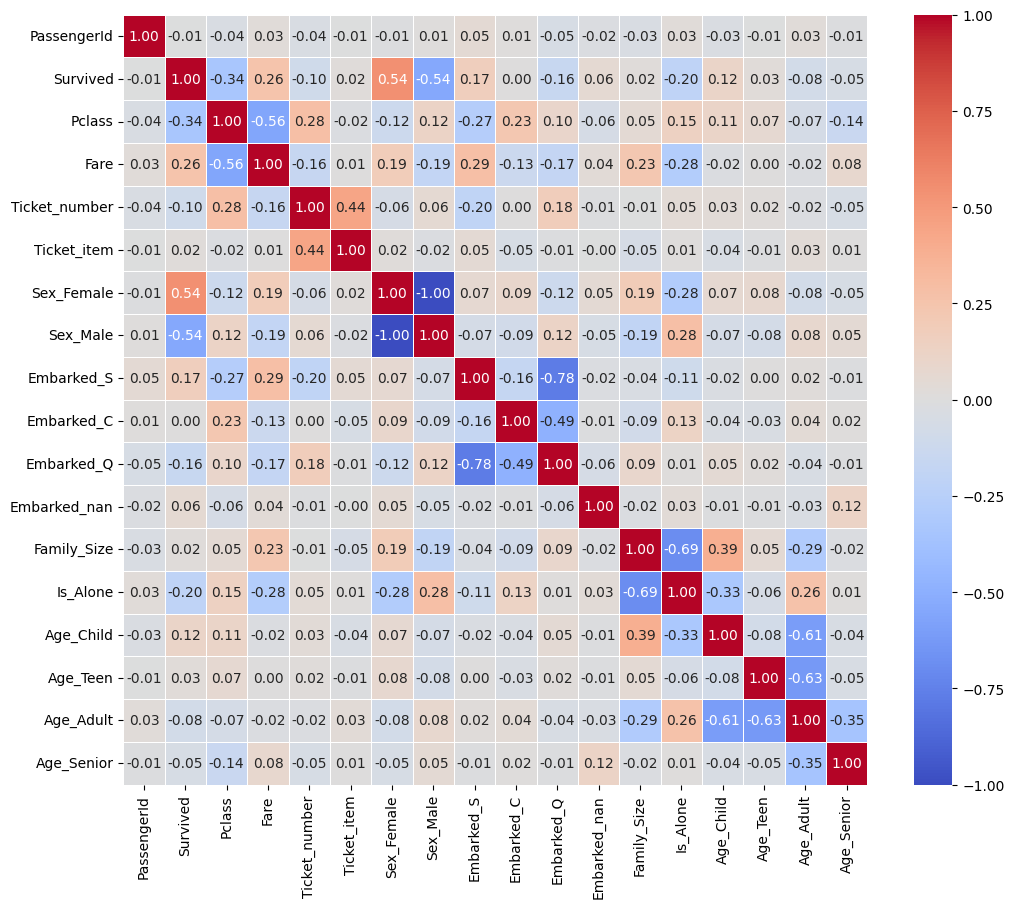

In [19]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [20]:
correlation_with_survived = data.corr()['Survived'].abs().sort_values(ascending=False)
threshold = 0.1
low_correlation_features = correlation_with_survived[correlation_with_survived < threshold].index
data.drop(low_correlation_features, axis=1, inplace=True)

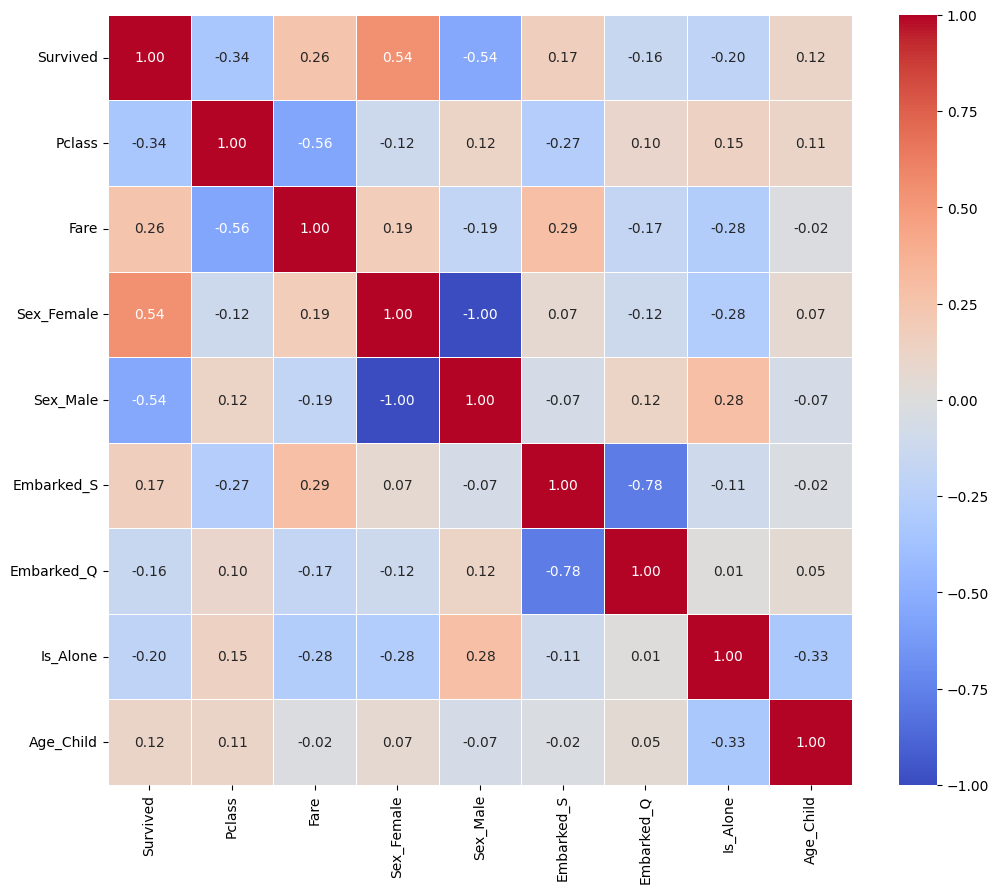

<bound method DataFrame.info of       Survived  Pclass      Fare  Sex_Female  Sex_Male  Embarked_S  \
0          0.0       3    7.2500         0.0       1.0         0.0   
1          1.0       1   71.2833         1.0       0.0         1.0   
2          1.0       3    7.9250         1.0       0.0         0.0   
3          1.0       1   53.1000         1.0       0.0         0.0   
4          0.0       3    8.0500         0.0       1.0         0.0   
...        ...     ...       ...         ...       ...         ...   
1304       NaN       3    8.0500         0.0       1.0         0.0   
1305       NaN       1  108.9000         1.0       0.0         1.0   
1306       NaN       3    7.2500         0.0       1.0         0.0   
1307       NaN       3    8.0500         0.0       1.0         0.0   
1308       NaN       3   22.3583         0.0       1.0         1.0   

      Embarked_Q  Is_Alone  Age_Child  
0            1.0         0          0  
1            0.0         0          0  
2      

In [21]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()
data.info

In [22]:
train_data = data.iloc[:len(train_data)]
test_data = data.iloc[len(train_data):]



In [23]:
X_train = train_data.drop('Survived', axis = 1)
X_test = test_data.drop('Survived', axis = 1)

y_train = train_data['Survived']

outliers_mask = np.abs((X_train['Fare'] - X_train['Fare'].mean()) / X_train['Fare'].std()) > 3
print("Before replacement:")
print(X_train['Fare'].values[outliers_mask])
X_train_no_outliers = X_train.copy()
X_train_no_outliers.loc[outliers_mask, 'Fare'] = X_train['Fare'].mean()
print("After replacement:")
print(X_train_no_outliers['Fare'].values[outliers_mask])

Before replacement:
[263.     263.     247.5208 512.3292 247.5208 262.375  263.     211.5
 227.525  263.     221.7792 227.525  512.3292 211.3375 227.525  227.525
 211.3375 512.3292 262.375  211.3375]
After replacement:
[32.20420797 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797
 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797
 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797
 32.20420797 32.20420797]


In [24]:
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10, 15, None],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy', 'log_loss']
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = DT()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train_scaled, y_train)
y_pred = best_dt_model.predict(X_test_scaled)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [25]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data_loading['PassengerId']
submission['Survived'] = y_pred
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('submission.csv', index = False)